In [4]:
import numpy as np
# import scipy as sp
from matplotlib import pyplot as plt
import torch
import signatory

In [5]:
d=2
M=150

def nilpotent(M):
    B = np.zeros((M,M))
    for i in range(2,M):
        B[i,i-1]=1.0
    return B

def canonical(i,M):
    e = np.zeros((M,1))
    e[i,0]=1.0
    return e

def vectorfieldoperator(state,increment):
    d = np.shape(increment)[0]
    N = np.shape(state)[0]
    direction = np.zeros((N,1))
    for i in range(d):
        helper = np.zeros((N,1))
        for j in range(N):
            helper[j]=np.sin((j+1)*state[j,0])
        direction=direction + helper*increment[i]
    return direction

def vectorfield2d(state,increment):
    return np.array([(2.0*np.sqrt(state[1]**2))**0.7,1.0*state[1]])*increment[0]\
            +np.array([(2.0*np.sqrt(state[1]**2))**0.7,0.0*state[1]])*increment[1]

def vectorfield2dsimple(state,increment):
    return np.array([2.0*state[1],1.0*state[1]])*increment[0]\
            +np.array([2.0*state[1],0.0*state[1]])*increment[1]

def vectorfield3d(state,increment):
    return np.array([np.sin(5*state[0])*np.exp(-state[2]),np.cos(5*state[1]),-state[2]*state[1]])*increment[0]+np.array([np.sin(4*state[1]),np.cos(4*state[0]),-state[0]*state[1]])*increment[1]
def vectorfield(state,increment):
    return 5*np.exp(-state)*increment[0] + 5*np.cos(state)*increment[1]
def randomAbeta(d,M):
    A = []
    beta = []
    for i in range(d):
        B = 0.0*nilpotent(M) + np.random.normal(0.0,0.5,size=(M,M)) 
        B = np.random.permutation(B)
        A = A + [B]
        beta = beta + [0.0*canonical(i,M)+np.random.normal(0.0,0.5,size=(M,1))]
    return [A,beta]

Abeta = randomAbeta(d,M)
A = Abeta[0]
beta = Abeta[1]

def sigmoid(x):
    return np.tanh(x)

def reservoirfield(state,increment):
    value = np.zeros((M,1))
    for i in range(d):
        value = value + sigmoid(np.matmul(A[i],state) + beta[i])*increment[i]
    return value

In [15]:
class SDE:
    def __init__(self,timehorizon,initialvalue,dimension,dimensionBM,dimensionR,vectorfield,timesteps,):
        self.timehorizon = timehorizon
        self.initialvalue = initialvalue # np array
        self.dimension = dimension
        self.dimensionBM = dimensionBM
        self.dimensionR = dimensionR
        self.vectorfield = vectorfield
        self.timesteps = timesteps

    def path(self):
        BMpath = [np.zeros(self.dimensionBM)]
        SDEpath = [np.array([1.0, self.initialvalue])]
        for i in range(self.timesteps):
            helper = np.random.normal(0,np.sqrt(self.timehorizon/self.timesteps),self.dimensionBM)
            BMpath = BMpath + [BMpath[-1]+helper]
            SDEpath = SDEpath + [np.exp(-0.0*self.timehorizon/self.timesteps)*(SDEpath[-1]+self.vectorfield(SDEpath[-1],helper))]

        return [BMpath, SDEpath]
    
    def anypath(self):
        BMpath = [np.zeros(self.dimensionBM)]
        SDEpath = [np.array([1.0, self.initialvalue])]#[np.ones((self.dimension,1))*self.initialvalue]
        
        for i in range(self.timesteps):
            helper = np.cos(BMpath[-1]*50)*self.timehorizon/self.timesteps#np.random.normal(0,np.sqrt(self.timehorizon/self.timesteps),self.dimensionBM)
            BMpath = BMpath + [BMpath[-1]+helper]
            SDEpath = SDEpath + [np.exp(-0.0*self.timehorizon/self.timesteps)*(SDEpath[-1]+self.vectorfield(SDEpath[-1],helper))]
            
        return [BMpath, SDEpath]
        
    def reservoir(self,BMpath):
        reservoirpath = [canonical(0,self.dimensionR)*self.initialvalue]
        for i in range(self.timesteps):
            increment = BMpath[i+1]-BMpath[i]
            reservoirpath = reservoirpath + [np.exp(-0.0*self.timehorizon/self.timesteps)*(reservoirpath[-1]+reservoirfield(reservoirpath[-1],increment))]
        return reservoirpath    
        

In [16]:
Sabr = SDE(1,1.0,2,d,M,vectorfield2dsimple,10000)
training = Sabr.path()

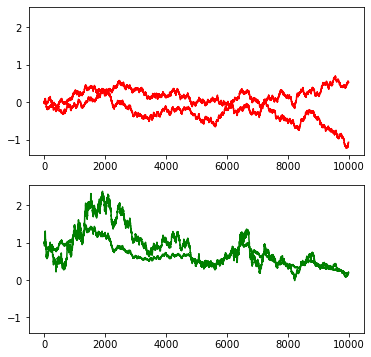

In [17]:
f1,p1=plt.subplots(2,1,figsize=(6,6),sharey=True)
p1[0].plot(training[0][:10000],'r')
p1[1].plot(training[1][:10000],'g')
#plt.savefig('trainingpath.pdf')
plt.show()

In [18]:
Y = training[1]
Ydata = np.squeeze(Y)
Ydatadiff = np.diff(Ydata,axis=0)
Ytrain = np.concatenate((Ydata[:1000],Ydatadiff[:1000:1]),axis=0)
np.shape(Ytrain)

(2000, 2)

In [19]:
BMpath=training[0]
X=Sabr.reservoir(BMpath)
Xdata = np.squeeze(X)
Xdatadiff = np.diff(Xdata,axis=0)
Xtrain=np.concatenate((Xdata[:1000],Xdatadiff[:1000:1]),axis=0)
np.shape(Xtrain)

(2000, 150)

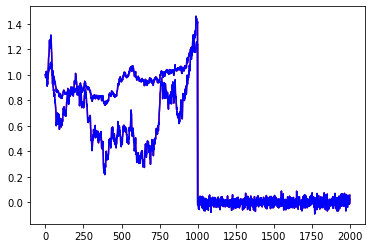

0.9999999733769798

In [20]:
from sklearn import linear_model
lm1 = linear_model.LinearRegression()
model1 = lm1.fit(Xtrain,Ytrain)
plt.plot(model1.predict(Xtrain),'r')
plt.plot(Ytrain,'b')
plt.show()
model1.score(Xtrain,Ytrain)
# model1.coef_

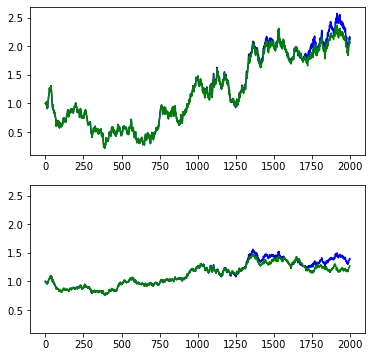

In [21]:
f,p=plt.subplots(2,1,figsize=(6,6),sharey=True)

N=2

for i in range(N):
    p[i].plot(model1.predict(Xdata[:2000])[:,i],'b')
    p[i].plot(Ydata[:2000,i],'g')
plt.savefig('training.pdf')
plt.show()

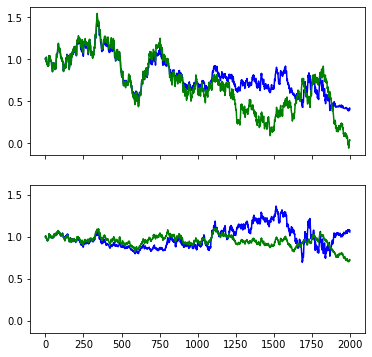

-1.5123082940095136

In [22]:
generalization = Sabr.path()
BMpath_test = generalization[0]
Y_test = generalization[1]
Ydata_test = np.squeeze(Y_test)

X_test = Sabr.reservoir(BMpath_test)
Xdata_test = np.squeeze(X_test)

N=2

fig,p=plt.subplots(N, 1, figsize=(6,6),sharex=True, sharey=True)
for i in range(N):
    p[i].plot(model1.predict(Xdata_test[:2000])[:,i],'b')
    p[i].plot(Ydata_test[:2000][:,i],'g')
#plt.savefig('generalization.pdf')
plt.show()
model1.score(Xdata_test[:2000],Ydata_test[:2000])

## Signature

In [94]:
BMpath=training[0]

path = np.array(BMpath)[None,:,:]
sig_path_stream = sig_stream(path,depth)
Xdata = sig_path_stream.numpy()[0,:,:]

Xdatadiff = np.diff(Xdata,axis=0)
Xtrain=np.concatenate((Xdata[:5000],Xdatadiff[:5000:1]),axis=0)
Xtrain = Xdata[:5000]
np.shape(Xtrain)

NameError: name 'sig_stream' is not defined

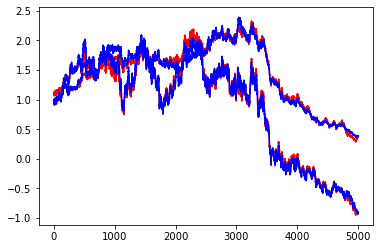

0.9857434662442706

In [320]:
from sklearn import linear_model
lm2 = linear_model.LinearRegression()
model2 = lm2.fit(Xtrain,Ytrain)
plt.plot(model2.predict(Xtrain),'r')
plt.plot(Ytrain,'b')
plt.show()
model2.score(Xtrain,Ytrain)
# model2.coef_

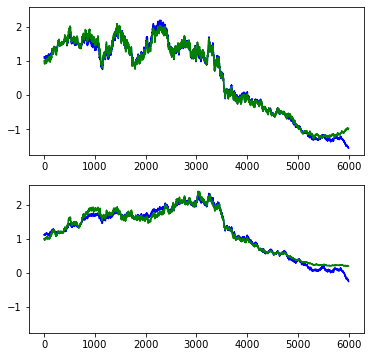

In [322]:
f,p=plt.subplots(2,1,figsize=(6,6),sharey=True)

N=2

for i in range(N):
    p[i].plot(model2.predict(Xdata[:6000])[:,i],'b')
    p[i].plot(Ydata[:6000][:,i],'g')
plt.savefig('training.pdf')
plt.show()

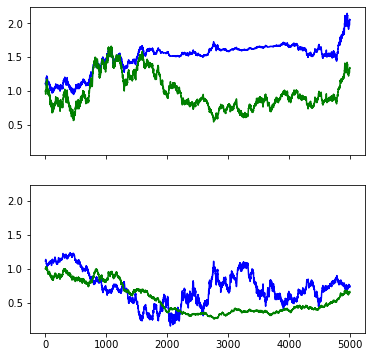

-2.9776524122051673

In [324]:
path = np.array(BMpath_test)[None,:,:]
sig_path_stream = sig_stream(path,depth)
Xdata_test = sig_path_stream.numpy()[0,:,:]

N=2

fig,p=plt.subplots(N, 1, figsize=(6,6),sharex=True, sharey=True)
for i in range(N):
    p[i].plot(model2.predict(Xdata_test[:5000])[:,i],'b')
    p[i].plot(Ydata_test[:5000][:,i],'g')
#plt.savefig('generalization.pdf')
plt.show()
model2.score(Xdata_test[:5000],Ydata_test[:5000])

### Using the wrong loss function?
### absolute value or relative change?
### Maybe increment make more sense

# Testing

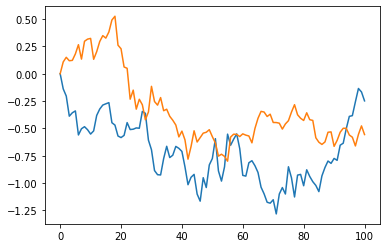

(1, 101, 2)

In [249]:
batch = 1
channels = 2
depth = 2
length = 100
T = 1
dt = T/length
path = np.random.normal(0,np.sqrt(dt),size = (1,length,channels))
path = np.cumsum(path,axis = 1)
path = np.concatenate([np.zeros([batch,1,channels]),path],axis = 1)
plt.plot(*path)
plt.show()
path.shape

In [250]:
index2word = signatory.all_words(channels, depth)
word2index = {}
for i,word in enumerate(index2word):
    word2index.update({word: i})
dim_sig = len(index2word)+1
sig_vectorfield = [np.zeros([dim_sig, dim_sig]) for i in range(channels)]
for i in range(dim_sig):
    if i > 0:
        res = (i-1)%channels
        word = index2word[i-1]
        if len(word) == 1:
            sig_vectorfield[res][i,0] = 1
        else:
            word_reduce = tuple(list(word)[:-1])
            sig_vectorfield[res][i,word2index[word_reduce]+1] = 1
print(dim_sig)

7


In [251]:
def sig_stream(path,depth):
    path = torch.Tensor(path)
    # make sure path start with 0
    batch, length, channels = path.shape
    length = length-1
    sig_path_split = [signatory.signature(path[:,i:i+2,:], depth) for i in range(length)] 
    add = sig_path_split[0]
    sig_path_stream = [add[:,None,:]]
    for i in range(len(sig_path_split)-1):
        add = signatory.signature_combine(add, sig_path_split[i+1], channels, depth)
        sig_path_stream.append(add[:,None,:])
    sig_path_stream = torch.cat(sig_path_stream,axis = 1)
    sig_path_stream = torch.cat([torch.ones([batch,length,1]),sig_path_stream],axis = 2)
    sig_path_stream = torch.cat([torch.zeros([batch,1,dim_sig]),sig_path_stream],axis = 1)
    sig_path_stream[:,0,0] = torch.ones(batch)
    return sig_path_stream
sig_path_stream = sig_stream(path,depth)
sig_path_stream.shape

torch.Size([1, 101, 7])

In [252]:
sig_vectorfield = []
for k in range(channels):
    V = np.zeros([dim_sig, dim_sig])
    i,j = k+1,0
    while i < dim_sig:
        V[i,j] = 1
        i = i + channels
        j = j +1
    sig_vectorfield.append(V)
def sig_dynamic(state,increment):
    value = np.zeros((batch,1,dim_sig))
    for i in range(d):
        value = value + (sig_vectorfield[i]@state.T).T * increment[:,i]
    return value
def sig_reservoir(path):
    reservoirpath = np.zeros([batch, length+1, dim_sig])
    reservoirpath[:,0,0] = np.ones(batch)
    for i in range(length):
        increment = path[:,i+1,:] - path[:,i,:]
        reservoirpath[:,i+1,:] = reservoirpath[:,i,:] + sig_dynamic(reservoirpath[:,i,:],increment)
    return reservoirpath
sig_path_reservoir = sig_reservoir(path)
sig_path_reservoir.shape

(1, 101, 7)

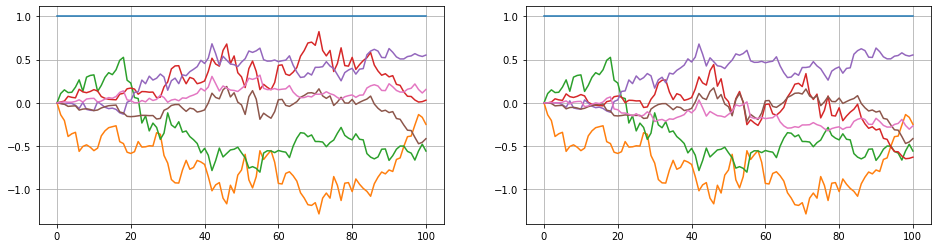

In [253]:
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(*sig_path_stream[:,:,:])
plt.grid()
# plt.legend(index2word)
plt.subplot(1,2,2)
plt.plot(*sig_path_reservoir[:,:,:])
plt.grid()
# plt.legend(index2word)
plt.show()
# Note they are not the same because Signatory make use of higher order tensor

In [172]:

# def randomA(d,M,MM):
#     A = []
#     for i in range(d):
#         B = np.random.permutation(np.random.normal(0.0,0.5,size=(MM,M)) )
#         A = A + [B.T@V[i]@B]
#     return A
# A = randomA(d,M,MM = dim_sig)
# # A = V
# def reservoirfield(state,increment):
#     value = np.zeros((M,1))
#     for i in range(d):
#         value = value + np.matmul(A[i],state)*increment[i]
#     return value
path = torch.tensor(BMpath)[None,:,:]
path_sig = sig_reservoir(path,depth = 3)
Zdata = path_sig[0,:,:].numpy()
Zdatadiff = np.diff(Zdata,axis=0)
Ztrain=np.concatenate((Zdata[:1000],Zdatadiff[:1000:1]),axis=0)
np.shape(Ztrain)

TypeError: sig_reservoir() got an unexpected keyword argument 'depth'